# **The M4 Competition: Prediction of Time Series Exercise**
<a id='top'></a>

### Author: Gregorio Mendoza Serrano 

## Table of Contents: 

0. [Introduction](#0)  
1. [Data Preparation](#1)  
2. [Holt-Winters Exponential Smoothing](#2)  
    1. [Model Construction](#21)  
    2. [Metrics Table](#22)  
3. [Random Forest Regressor](#3)  
    1. [Model Construction](#31)  
    2. [Metrics Table](#32)  
4. [Convolutional Neural Network (CNN)](#4)  
    1. [Model Construction](#41)  
    2. [Metrics Table](#42)  
5. [Temporal Convolutional Neural Network (TCN)](#5)  
    1. [Model Construction](#51)  
    2. [Metrics Table](#52)  
6. [ARIMA (Autoregressive Integrated Moving Average)](#6)  
    1. [Model Construction](#61)  
    2. [Metrics Table](#62)  
7. [GRU (Gated Recurrent Unit)](#7)  
    1. [Model Construction](#71)  
    2. [Metrics Table](#72)  
8. [Performance Comparison](#8)  
    1. [NRMSE Histograms](#81)  
    2. [Conclusions](#82)  

---  

# 0. Introduction <a id="0"></a>  

<span style="color:red">Note: This notebook is prepared to run in a local environment</span>  

The M4 dataset consists of time series data at annual, quarterly, monthly, and other frequencies (weekly, daily, and hourly), divided into training and testing sets. The minimum number of observations in the training test is 13 for annual series, 16 for quarterly, 42 for monthly, 80 for weekly, 93 for daily, and 700 for hourly. Participants were asked to make the following number of forecasts beyond the available data: six for annual series, eight for quarterly, 18 for monthly, 13 for weekly, and 14 and 48 forecasts respectively for daily and hourly.

During this exercise, 60 time series will be randomly selected from all contained in the M4 dataset, which will be subjected to predictive analysis using six different models (details of which are elaborated in the corresponding section). 

The distribution of selected time series will be 10 for each periodicity type: *Hourly, Daily, Weekly, Quarterly, Monthly,* and *Yearly*.

The six models to be trained and tested in this document are:
- Holt-Winters Exponential Smoothing
- Random Forest Regressor
- Convolutional Neural Network (CNN)
- Temporal Convolutional Neural Network (TCN)
- ARIMA (Autoregressive Integrated Moving Average)
- GRU (Gated Recurrent Unit)  

The result of the analysis using each model is the extraction of a metrics table that includes the following measures for each of the previously mentioned time series:

- **NRMSE (Normalized Root Mean Squared Error):**
  - A measure that evaluates the accuracy of a time series prediction model by comparing the square root of the mean squared error with the standard deviation of the data.
  - Formula: $ NRMSE = \frac{RMSE}{\text{Standard deviation of the data}} $

- **RMSE (Root Mean Squared Error):**
  - A metric that calculates the square root of the average squared difference between predicted values and actual values of the time series.
  - Formula: $ RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2} $

- **MSE (Mean Squared Error):**
  - Represents the average of the squares of the errors between the model predictions and the actual values of the time series.
  - Formula: $ MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 $

- **MAPE (Mean Absolute Percentage Error):**
  - A measure of error that calculates the average of absolute percentage errors between predictions and actual values of the time series.
  - Formula: $ MAPE = \frac{1}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat{y}_i}{y_i} \right| \times 100\% $

- **MAE (Mean Absolute Error):**
  - The average of the absolute values of the errors between model predictions and actual values of the time series.
  - Formula: $ MAE = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i| $

These metrics will be used to evaluate the accuracy and performance of the time series prediction models in this exercise, leading to conclusions at the end of the document. 
 
> Special emphasis will be placed on **NRMSE (Normalized Root Mean Squared Error)**, as it provides a "percentage idea" of the error magnitude made by the algorithm when predicting the test part of the time series.

[Return to the beginning of the document](#) 

---  

# 1. Data Preparation <a id="1"></a>  

We import the necessary libraries to get started:


In [80]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [81]:
import warnings

# Desactivar las advertencias temporariamente
warnings.filterwarnings('ignore')

Let's import the file `M4-info.csv`

In [82]:
ruta_archivo_info = 'Dataset/M4-info.csv'
M4_info = pd.read_csv(ruta_archivo_info)
M4_info.set_index(M4_info.columns[0], inplace=True)
M4_info.head()

,category,Frequency,Horizon,SP,StartingDate
M4id,,,,,
Y1,Macro,1,6,Yearly,01-01-79 12:00
Y2,Macro,1,6,Yearly,01-01-79 12:00
Y3,Macro,1,6,Yearly,01-01-79 12:00
Y4,Macro,1,6,Yearly,01-01-79 12:00
Y5,Macro,1,6,Yearly,01-01-79 12:00


We define a function to randomly sample eight indices for each 'SP' category (eight indices from each dataset). This will give us a total of 60 indices, aligning with the 50 time series requested in the exercise.


In [83]:
# Función para obtener ocho índices aleatorios por cada valor de SP
def sample_indices_by_category(df, column, n=10):
    
    np.random.seed(3)
    unique_values = df[column].unique()
    sampled_indices = {}

    for value in unique_values:
        indices = df[df[column] == value].index
        if len(indices) >= n:
            sampled_indices[value] = np.random.choice(indices, n, replace=False)
        else:
            sampled_indices[value] = np.random.choice(indices, len(indices), replace=False)

    return sampled_indices

We extract the random indices (having defined a fixed seed to obtain the same result each time) and display them on the screen:


In [84]:
# Obtener ocho índices aleatorios por cada valor de SP
indices_random = sample_indices_by_category(M4_info, 'SP')

# Mostrar los índices obtenidos
print("\nÍndices aleatorios por cada valor de SP:")
for value, idx in indices_random.items():
    print(f"Valor {value}: {idx}")


Índices aleatorios por cada valor de SP:
Valor Yearly: ['Y3295' 'Y7079' 'Y12246' 'Y12866' 'Y14703' 'Y8921' 'Y2375' 'Y1839'
 'Y9158' 'Y18963']
Valor Quarterly: ['Q10907' 'Q8388' 'Q18309' 'Q4347' 'Q11037' 'Q21035' 'Q5346' 'Q17833'
 'Q7219' 'Q5404']
Valor Monthly: ['M41875' 'M33542' 'M22577' 'M11243' 'M15683' 'M31321' 'M27927' 'M40797'
 'M10776' 'M29996']
Valor Weekly: ['W138' 'W278' 'W5' 'W314' 'W318' 'W50' 'W336' 'W266' 'W222' 'W242']
Valor Daily: ['D3550' 'D2234' 'D2705' 'D4100' 'D2267' 'D3290' 'D2515' 'D177' 'D1355'
 'D2608']
Valor Hourly: ['H290' 'H355' 'H228' 'H150' 'H167' 'H9' 'H193' 'H208' 'H377' 'H210']


We define a function to import all .csv files from a folder and create a dictionary of dataframes (which will have the name of the source file without the extension):


In [85]:
# Función para importar todos los archivos CSV de una carpeta
def importar_archivos_csv(carpeta):
    """
    Importa todos los archivos CSV de una carpeta y crea un DataFrame para cada uno.
    El nombre del DataFrame será el nombre del archivo CSV (sin extensión).
    
    :param carpeta: Ruta a la carpeta que contiene los archivos CSV.
    :return: Diccionario con los DataFrames, donde la clave es el nombre del archivo CSV (sin extensión).
    """
    dataframes = {}
    for archivo in os.listdir(carpeta):
        if archivo.endswith('.csv'):
            nombre_df = os.path.splitext(archivo)[0]
            ruta_archivo = os.path.join(carpeta, archivo)
            dataframes[nombre_df] = pd.read_csv(ruta_archivo)
            # Hacer que la primera columna sea el índice
            dataframes[nombre_df].set_index(dataframes[nombre_df].columns[0], inplace=True)
    return dataframes

We import all the .csv files from Train and Test:  


In [86]:
carpeta_train = 'Dataset/Train'
carpeta_test = 'Dataset/Test'

train_data = importar_archivos_csv(carpeta_train)
test_data = importar_archivos_csv(carpeta_test)


We define a function to print datasets on the screen for a quick visualization:  


In [87]:
def print_dataframe(nombre_dataframe_deseado):
    # Comprobar si el DataFrame existe y luego imprimirlo
    if nombre_dataframe_deseado in test_data:
        print(f"DataFrame: {nombre_dataframe_deseado}")
        print(test_data[nombre_dataframe_deseado])
    else:
        print(f"El DataFrame con el nombre '{nombre_dataframe_deseado}' no existe.")


We create a function to obtain the number of records in each dataset:  


In [89]:
# Función para imprimir el número de registros de cada DataFrame en el diccionario
def print_num_records(datasets_dict):
    for key, df in datasets_dict.items():
        print(f"El dataset '{key}' tiene {len(df)} registros.")


We query the previous function to find out the number of records in each dataset (as a check):  


In [90]:
# Llamar a la función para imprimir el número de registros
print_num_records(train_data)
print_num_records(test_data)

El dataset 'Daily-train' tiene 4227 registros.
El dataset 'Hourly-train' tiene 414 registros.
El dataset 'Monthly-train' tiene 48000 registros.
El dataset 'Quarterly-train' tiene 24000 registros.
El dataset 'Weekly-train' tiene 359 registros.
El dataset 'Yearly-train' tiene 23000 registros.
El dataset 'Daily-test' tiene 4227 registros.
El dataset 'Hourly-test' tiene 414 registros.
El dataset 'Monthly-test' tiene 48000 registros.
El dataset 'Quarterly-test' tiene 24000 registros.
El dataset 'Weekly-test' tiene 359 registros.
El dataset 'Yearly-test' tiene 23000 registros.


We create dataframes dedicated to each type of series with only the selected records:


In [92]:
# Creación de dataframes de análisis de entrenamiento:
df_daily_train = train_data['Daily-train'].loc[indices_random['Daily']]
df_hourly_train = train_data['Hourly-train'].loc[indices_random['Hourly']]
df_monthly_train = train_data['Monthly-train'].loc[indices_random['Monthly']]
df_quarterly_train = train_data['Quarterly-train'].loc[indices_random['Quarterly']]
df_weekly_train = train_data['Weekly-train'].loc[indices_random['Weekly']]
df_yearly_train = train_data['Yearly-train'].loc[indices_random['Yearly']]

# Creación de dataframes de análisis de test:
df_daily_test = test_data['Daily-test'].loc[indices_random['Daily']]
df_hourly_test = test_data['Hourly-test'].loc[indices_random['Hourly']]
df_monthly_test = test_data['Monthly-test'].loc[indices_random['Monthly']]
df_quarterly_test = test_data['Quarterly-test'].loc[indices_random['Quarterly']]
df_weekly_test = test_data['Weekly-test'].loc[indices_random['Weekly']]
df_yearly_test = test_data['Yearly-test'].loc[indices_random['Yearly']]

We concatenate the previous datasets into two single datasets: one for training and another for testing.  


In [93]:
# Concatenar los DataFrames en uno solo
df_train = pd.concat([df_daily_train, df_hourly_train, df_monthly_train, df_quarterly_train, df_weekly_train, df_yearly_train])
df_test = pd.concat([df_daily_test, df_hourly_test, df_monthly_test, df_quarterly_test, df_weekly_test, df_yearly_test])


We now create a function that extracts an array from each row of the previous datasets without the null values:  



In [95]:
def dataframe_to_array_without_nans(df):
    """
    Transforma cada fila de un DataFrame en un array, eliminando los valores NaN de cada fila.
    
    Parameters:
    df (pd.DataFrame): DataFrame de entrada.
    
    Returns:
    list: Lista de arrays, uno por cada fila del DataFrame.
    """
    # Aplicar una función a cada fila del DataFrame
    result = df.apply(lambda row: row.dropna().values, axis=1)
    
    # Convertir el resultado a una lista de arrays
    result_list = [np.array(arr) for arr in result]
    
    return result_list


We create the training arrays:  



In [96]:
Yearly_train = dataframe_to_array_without_nans(df_yearly_train)
Hourly_train = dataframe_to_array_without_nans(df_hourly_train)
Monthly_train = dataframe_to_array_without_nans(df_monthly_train)
Quarterly_train = dataframe_to_array_without_nans(df_quarterly_train)
Weekly_train = dataframe_to_array_without_nans(df_weekly_train)
Daily_train = dataframe_to_array_without_nans(df_daily_train)

  
We create the test arrays:  


In [97]:
Yearly_test = dataframe_to_array_without_nans(df_yearly_test)
Hourly_test = dataframe_to_array_without_nans(df_hourly_test)
Monthly_test = dataframe_to_array_without_nans(df_monthly_test)
Quarterly_test = dataframe_to_array_without_nans(df_quarterly_test)
Weekly_test = dataframe_to_array_without_nans(df_weekly_test)
Daily_test = dataframe_to_array_without_nans(df_daily_test)



We introduce the previous arrays into two dictionaries with their identification:  


In [98]:
train = {
    'Hourly': Hourly_train,
    'Daily': Daily_train,
    'Weekly': Weekly_train,
    'Quarterly': Quarterly_train,
    'Monthly': Monthly_train,
    'Yearly': Yearly_train
}

test = {
    'Hourly': Hourly_test,
    'Daily': Daily_test,
    'Weekly': Weekly_test,
    'Quarterly': Quarterly_test,
    'Monthly': Monthly_test,
    'Yearly': Yearly_test
}


We create a function to evaluate the predictions:  


In [99]:
# Función para evaluar las predicciones
def evaluate_predictions(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((true - predicted) / true)) * 100
    nrmse = rmse / (np.max(true) - np.min(true))
    return nrmse, rmse, mse, mape, mae

 
We create a function to add a row to a dataframe adjusted to our case:


In [100]:
def agregar_fila_a_dataframe(df, modelo, period, ID, evaluation):

    # Crear una nueva fila con los valores específicos
    nueva_fila = {
        'MODELO': modelo,
        'PERIOD': period,
        'ID': ID,
        'NRMSE': evaluation[0],
        'RMSE': evaluation[1],
        'MSE': evaluation[2],
        'MAPE': evaluation[3],
        'MAE': evaluation[4]
    }

    # Convertir la nueva fila en un DataFrame
    df_nueva_fila = pd.DataFrame([nueva_fila])

    # Excluir columnas vacías o con todos los valores NaN antes de la concatenación
    df_nueva_fila = df_nueva_fila.dropna(axis=1, how='all')

    # Añadir la nueva fila al DataFrame original utilizando pd.concat
    df = pd.concat([df, df_nueva_fila], ignore_index=True, sort=False)

    return df

[Back to Top](#)

---

# 2. Exponential Smoothing Holt-Winters <a id="2"></a>

The triple exponential smoothing method of Holt-Winters is a technique used to predict future values in time series that exhibit trends and seasonality. It works best with data that shows a stable trend over time and a repetitive seasonal pattern.

The method is based on three equations that are updated iteratively with each new observation:

1. Simple exponential smoothing to eliminate random fluctuations
2. Double exponential smoothing to model trends 
3. Triple exponential smoothing to model seasonality

**Basic formulas:**

- Level: $ l_t = \alpha \frac{y_t}{s_{t-p}} + (1-\alpha)(l_{t-1} + b_{t-1}) $

- Trend: $ b_t = \beta (l_t - l_{t-1}) + (1-\beta)b_{t-1} $

- Seasonality: $ s_t = \gamma \frac{y_t}{l_t} + (1-\gamma)s_{t-p} $

- Prediction: $ \hat{y}_{t+h} = (l_t + hb_t) s_{t-p+h} $

where $ \alpha, \beta, \gamma $ are smoothing parameters and $ p $ is the seasonal period.

## 2.1. Model Construction <a id="21"></a>

Let's first import the necessary libraries:


In [101]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

We create a dataframe to store the evaluation results of metrics:  

In [102]:
# Creación del DataFrame externo a la función
nombres_columnas = ['MODELO', 'PERIOD', 'ID', 'NRMSE', 'RMSE', 'MSE', 'MAPE', 'MAE']
df_HW = pd.DataFrame(columns=nombres_columnas)


We iterate the model through all the previously selected time series, storing the results of each time series in a row of the dataframe created earlier:  



In [104]:
model_name = 'HW'
seasonal_periods=6

for period in train:

    for i in range(10):

        train_data = train[period][i]
        test_data = test[period][i]

        train_series = pd.Series(train_data)
        test_series = pd.Series(test_data)
        
        # Ajustar el modelo Holt-Winters
        model = ExponentialSmoothing(train_series, trend='add', seasonal='add', seasonal_periods=seasonal_periods)
        hw_fit = model.fit()
        
        # Realizar predicciones
        predictions = hw_fit.forecast(len(test_data))
        
        # Evaluar el modelo y añadimos fila al dataset de evaluaciones:
        evaluation = evaluate_predictions(test_series, predictions)
        df_HW = agregar_fila_a_dataframe(df_HW, model_name, period, indices_random[period][i], evaluation)

## 2.2. Metrics Table <a id="22"></a>

We display the table resulting from the previous code:  


In [105]:
df_HW

,MODELO,PERIOD,ID,NRMSE,RMSE,MSE,MAPE,MAE
0,HW,Hourly,H290,2.060347,26.784512,7.174101e+02,NaN,23.158385
1,HW,Hourly,H355,0.617783,98.845337,9.770401e+03,NaN,85.017387
2,HW,Hourly,H228,1.295016,11.525647,1.328405e+02,NaN,10.660336
3,HW,Hourly,H150,0.467628,156.655219,2.454086e+04,NaN,128.065656
4,HW,Hourly,H167,0.413017,156.533280,2.450267e+04,NaN,125.016310
5,HW,Hourly,H9,2.231280,33964.541396,1.153590e+09,NaN,28374.340790
6,HW,Hourly,H193,1.666885,15.668716,2.455087e+02,NaN,13.589048
7,HW,Hourly,H208,2.179396,20.050443,4.020202e+02,NaN,17.360168
8,HW,Hourly,H377,0.416444,55.803542,3.114035e+03,NaN,44.001825
9,HW,Hourly,H210,2.108057,20.658959,4.267926e+02,NaN,17.968900



We show a description of the previous dataframe:  



In [106]:
df_HW.describe()

,NRMSE,RMSE,MSE,MAE
count,60.000000,60.000000,6.000000e+01,60.000000
mean,0.639984,926.089493,1.955765e+07,774.694113
std,0.514390,4360.843939,1.488863e+08,3642.959311
min,0.095564,11.525647,1.328405e+02,10.660336
25%,0.358577,75.027046,5.649204e+03,63.340652
50%,0.457201,161.896377,2.621683e+04,135.732829
75%,0.656380,472.091341,2.228781e+05,409.121700
max,2.231280,33964.541396,1.153590e+09,28374.340790



[Back to the beginning of the document](#)


---

# 3. Random Forest Regressor <a id="3"></a>

A Random Forest regression algorithm is a machine learning technique that combines multiple decision trees to make predictions. It is based on the idea of "ensembling" several decision trees to improve accuracy and avoid overfitting. Each tree in the forest takes a random sample of features and training data, which helps to reduce variance and improve the generalization of the model.

In the context of time series prediction, Random Forest can be used to model trends and patterns in the data over time.

In summary, a Random Forest regression algorithm is a powerful tool for time series prediction, as it can capture complex patterns and trends in the data over time, enhancing the accuracy of predictions.

## 3.1. Model Construction <a id="31"></a>

We import the necessary libraries:


In [107]:
from sklearn.ensemble import RandomForestRegressor


We create the function that encapsulates the Random Forest model:  



In [108]:
def random_forest_time_series_prediction(train_data, test_data, lags=5):
    """
    Realiza una predicción de serie temporal utilizando un modelo Random Forest.

    Parameters:
    train_data (np.ndarray): Array de datos de entrenamiento.
    test_data (np.ndarray): Array de datos de prueba.
    lags (int): Número de retardos para crear características.

    Returns:
    np.ndarray: Valores predichos por el modelo.
    """
    # Concatenar los conjuntos de datos para crear características de retardos
    data = np.concatenate([train_data, test_data])

    # Crear características basadas en ventanas deslizantes
    def create_lagged_features(data, lags=5):
        df = pd.DataFrame(data, columns=['y'])
        for lag in range(1, lags + 1):
            df[f'lag_{lag}'] = df['y'].shift(lag)
        return df.dropna()

    df_lagged = create_lagged_features(data, lags)

    # Dividir en características y etiquetas
    X = df_lagged.drop(['y'], axis=1).values
    y = df_lagged['y'].values

    # Determinar el punto de división para entrenamiento y prueba
    split = len(train_data)
    X_train, X_test = X[:split - lags], X[split - lags:]
    y_train, y_test = y[:split - lags], y[split - lags:]

    # Crear el modelo Random Forest
    model = RandomForestRegressor(n_estimators=200)
    model.fit(X_train, y_train)

    # Realizar la predicción
    predicted = model.predict(X_test)

    # Graficar la predicción
    #plot_results(test_data, predicted, label='Predicción RF')

    return predicted

We create a dataframe to store the evaluation results of metrics:  


In [109]:
# Creación del DataFrame externo a la función
nombres_columnas = ['MODELO', 'PERIOD', 'ID', 'NRMSE', 'RMSE', 'MSE', 'MAPE', 'MAE']
df_RF = pd.DataFrame(columns=nombres_columnas)

We iterate the model through all the previously selected time series, storing the results of each time series in a row of the dataframe created earlier:  


In [110]:
model_name = 'RF'

for period in train:

    for i in range(10):
        rf_predictions = random_forest_time_series_prediction(train[period][i], test[period][i], lags=5)
        evaluation = evaluate_predictions(test[period][i], rf_predictions)
        df_RF = agregar_fila_a_dataframe(df_RF, model_name, period, indices_random[period][i], evaluation)


## 3.2. Metrics Table <a id="32"></a>
We display the table resulting from the previous code:  

In [111]:
df_RF

,MODELO,PERIOD,ID,NRMSE,RMSE,MSE,MAPE,MAE
0,RF,Hourly,H290,0.058922,0.765980,5.867257e-01,2.850938,0.640312
1,RF,Hourly,H355,0.121943,19.510936,3.806766e+02,17.949467,14.174062
2,RF,Hourly,H228,0.017528,0.156003,2.433688e-02,0.571075,0.109948
3,RF,Hourly,H150,0.090150,30.200319,9.120593e+02,29.057078,21.485208
4,RF,Hourly,H167,0.055467,21.022092,4.419284e+02,18.600009,14.948542
5,RF,Hourly,H9,0.023097,351.575487,1.236053e+05,0.747154,255.646563
6,RF,Hourly,H193,0.046981,0.441619,1.950272e-01,1.691003,0.352523
7,RF,Hourly,H208,0.056577,0.520507,2.709278e-01,2.054596,0.418059
8,RF,Hourly,H377,0.114715,15.371856,2.362940e+02,19.333273,10.957604
9,RF,Hourly,H210,0.030202,0.295978,8.760319e-02,1.007566,0.214561



We display also de description of the table resulting from the previous code:  


In [112]:
df_RF.describe()

,NRMSE,RMSE,MSE,MAPE,MAE
count,60.000000,60.000000,6.000000e+01,60.000000,60.000000
mean,0.392322,414.781905,5.491592e+05,8.347141,348.823771
std,0.249858,619.279416,1.729530e+06,10.096745,539.456219
min,0.017528,0.156003,2.433688e-02,0.327987,0.109948
25%,0.237650,41.351502,1.711335e+03,1.779601,37.278749
50%,0.359642,145.160916,2.165657e+04,4.389419,121.449590
75%,0.531440,469.982704,2.211351e+05,12.637282,403.604167
max,1.139628,3499.049219,1.224335e+07,58.976128,3096.218333



[Back to the beginning of the document](#)

---

# 4. Convolutional Neural Network (CNN) <a id="4"></a>

A Convolutional Neural Network (CNN) model for time series prediction is a type of neural network originally designed to process image data but has also been successfully applied to time series.

CNNs use convolutional filters to detect local patterns in the data and extract relevant features for prediction. In the context of time series, CNNs perform convolutions over time, thus capturing recurring patterns across different periods.

The typical architecture of a CNN for time series includes:

- 1D convolutional layers to extract features
- Flattening layers to convert the data into a vector 
- Fully connected layers for prediction

These networks are trained by minimizing a loss function such as the mean squared error between predictions and actual values.

CNNs are particularly useful when looking for repetitive patterns in the time series, allowing for accurate predictions by focusing on the most relevant moments.

## 4.1. Model Construction <a id="41"></a>

Let's import the necessary libraries:


In [113]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten
from tensorflow.keras.optimizers import Adam

**Model Architecture:**

The model consists of the following layers:

1. **Input Layer (Conv1D):**
   - This layer applies one-dimensional convolution operations to the time series input.
   - It uses 32 filters of size 3 and a ReLU activation function.
   - The input shape is `input_shape`.

2. **Convolutional Layer (Conv1D):**
   - This layer applies a second one-dimensional convolution operation.
   - It uses 64 filters of size 3 and a ReLU activation function.

3. **Flatten Layer:**
   - This layer converts the output of the convolutional layers into a one-dimensional vector.

4. **Dense Layer:**
   - This layer is a fully connected layer with 64 units and a ReLU activation function.

5. **Output Layer (Dense):**
   - This output layer has a single unit and does not use an activation function, as it is a regression problem to predict a numerical value.
We define the functions to prepare the input data and the architecture of the model itself:


Let's define the functions to prepare the input data and the architecture of the model itself:

In [283]:
def preparar_datos(serie_temporal, longitud_secuencia):
    """
    Prepara los datos para el modelado de series temporales.
    :param serie_temporal: Serie temporal como array numpy.
    :param longitud_secuencia: Número de pasos hacia atrás en la secuencia.
    :return: Tupla de características X y etiquetas y.
    """
    if longitud_secuencia > len(serie_temporal):
        raise ValueError("La longitud de la secuencia es mayor que la longitud de la serie temporal")
    elif longitud_secuencia == len(serie_temporal):
        return np.array([serie_temporal[:-1]]), np.array([serie_temporal[-1]])
    else:
        X, y = [], []
        for i in range(len(serie_temporal) - longitud_secuencia):
            secuencia = serie_temporal[i:(i + longitud_secuencia)]
            X.append(secuencia)
            y.append(serie_temporal[i + longitud_secuencia])
        return np.array(X), np.array(y)

def crear_modelo_cnn(input_shape):
    """
    Crea y retorna un modelo de red neuronal convolucional para predicción de series temporales.
    :param input_shape: Tupla que especifica la forma de los datos de entrada (dimensiones).
    :return: Modelo de red neuronal convolucional.
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(32, 3, activation='relu', input_shape=input_shape),
        tf.keras.layers.Conv1D(64, 3, activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1)  # Capa de salida para la predicción
    ])
    return model

def entrenar_modelo(modelo, X_train, y_train, epochs=20, batch_size=32, verbose=0):
    """
    Entrena el modelo de red neuronal convolucional.
    :param modelo: Modelo de red neuronal convolucional.
    :param X_train: Datos de entrenamiento (dimensiones: [número de muestras, longitud de la secuencia, número de características]).
    :param y_train: Etiquetas de entrenamiento.
    :param epochs: Número de épocas de entrenamiento.
    :param batch_size: Tamaño del lote durante el entrenamiento.
    """
    modelo.compile(optimizer='adam', loss='mean_squared_error')
    modelo.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)

def evaluar_modelo(modelo, X_test, y_test):
    """
    Evalúa el modelo de red neuronal convolucional.
    :param modelo: Modelo de red neuronal convolucional entrenado.
    :param X_test: Datos de prueba (dimensiones: [número de muestras, longitud de la secuencia, número de características]).
    :param y_test: Etiquetas de prueba.
    :return: Vector con las métricas de evaluación en el orden ['NRMSE', 'RMSE', 'MSE', 'MAPE', 'MAE'].
    """
    predicciones = modelo.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, predicciones))
    mse = mean_squared_error(y_test, predicciones)
    mape = np.mean(np.abs((y_test - predicciones) / y_test)) * 100
    mae = np.mean(np.abs(y_test - predicciones))

    # NRMSE (Normalized Root Mean Squared Error)
    nrmse = rmse / np.mean(y_test)

    return [nrmse, rmse, mse, mape, mae]


We create a dataframe to store the evaluation results of metrics:  


In [115]:
# Creación del DataFrame externo a la función
nombres_columnas = ['MODELO', 'PERIOD', 'ID', 'NRMSE', 'RMSE', 'MSE', 'MAPE', 'MAE']
df_CNN = pd.DataFrame(columns=nombres_columnas)

We iterate the model through all the previously selected time series, storing the results of each time series in a row of the dataframe created earlier:  


In [116]:
model_name = 'CNN'

for period in train:

    for i in range(10):
        
        # Definimos datos de train y test:
        train_data = train[period][i]
        test_data = test[period][i]

        # Parámetros
        longitud_secuencia = 5
        
        X_train, y_train = preparar_datos(train_data, longitud_secuencia)
        X_test, y_test = preparar_datos(test_data, longitud_secuencia)    
        
        # Ajustar dimensiones para CNN (agregar una dimensión para los canales)
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
        X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))  

        # Crear modelo
        modelo = crear_modelo_cnn(input_shape=(longitud_secuencia, 1))

        # Entrenar modelo
        entrenar_modelo(modelo, X_train, y_train)

        # Elaboramos predicciones y evaluamos:
        evaluation = evaluar_modelo(modelo, X_test, y_test)    
        
        df_CNN = agregar_fila_a_dataframe(df_CNN, model_name, period, indices_random[period][i], evaluation)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000021B6E273A60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
2/

## 4.2. Metrics Table <a id="42"></a>
We display the table resulting from the previous code:  


In [117]:
df_CNN

,MODELO,PERIOD,ID,NRMSE,RMSE,MSE,MAPE,MAE
0,CNN,Hourly,H290,0.041475,1.004944,1.009912e+00,22.536607,5.212320
1,CNN,Hourly,H355,0.307225,29.079165,8.455979e+02,95.574074,54.712350
2,CNN,Hourly,H228,0.033662,0.705888,4.982778e-01,18.802200,3.799879
3,CNN,Hourly,H150,0.347618,37.720581,1.422842e+03,189.733635,90.262776
4,CNN,Hourly,H167,0.236786,36.542185,1.335331e+03,322.304506,141.179610
5,CNN,Hourly,H9,0.033809,1167.955510,1.364120e+06,19.663312,6521.917724
6,CNN,Hourly,H193,0.024679,0.534673,2.858757e-01,17.527561,3.678338
7,CNN,Hourly,H208,0.034425,0.730525,5.336673e-01,17.788189,3.693821
8,CNN,Hourly,H377,0.276451,20.206640,4.083083e+02,115.511573,45.215739
9,CNN,Hourly,H210,0.034814,0.773118,5.977109e-01,18.238820,3.926277


We show the description of the previous table:  


In [118]:
df_CNN.describe()

,NRMSE,RMSE,MSE,MAPE,MAE
count,60.000000,60.000000,6.000000e+01,60.000000,60.000000
mean,0.104275,335.238405,3.129262e+05,22.135984,416.524580
std,0.171815,451.597633,7.180019e+05,51.226039,894.742721
min,0.001727,0.534673,2.858757e-01,0.172727,3.678338
25%,0.016286,35.121502,1.239575e+03,1.510162,40.445504
50%,0.037070,139.732940,1.952565e+04,5.062840,142.759779
75%,0.131151,484.302877,2.345701e+05,17.900846,484.302877
max,1.118953,1990.617556,3.962558e+06,322.304506,6521.917724


[Back to the beginning of the document](#)


---
# 5. Deeper Convolutional Neural Network (D-CNN) <a id="5"></a>

Next, a version with more parameters of the previous convolutional neural network will be trained.

## 5.1. Model Construction <a id="51"></a>

The architecture of this model is as follows:

- **Conv1D Layer**: 32 filters, kernel size 3, ReLU activation, input shape `input_shape`.
- **Conv1D Layer**: 128 filters, kernel size 3, ReLU activation.
- **Flatten Layer**: Flattens the output to connect with dense layers.
- **Dense Layer**: 128 units, ReLU activation.
- **Dense Layer**: 32 units, ReLU activation.
- **Dense Layer (Output)**: 1 unit, linear activation for prediction.

This architecture extracts local features and captures complex relationships in time series data.  

The data preparation function is common to the CNN model from the previous section.



In [309]:
def crear_modelo_dcnn(input_shape):
    """
    Crea y retorna un modelo de red neuronal convolucional para predicción de series temporales.
    :param input_shape: Tupla que especifica la forma de los datos de entrada (dimensiones).
    :return: Modelo de red neuronal convolucional.
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(32, 3, activation='relu', input_shape=input_shape),
        tf.keras.layers.Conv1D(128, 3, activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1)  # Capa de salida para la predicción
    ])
    return model

def entrenar_modelo(modelo, X_train, y_train, epochs=20, batch_size=32, verbose=0):
    """
    Entrena el modelo de red neuronal convolucional.
    :param modelo: Modelo de red neuronal convolucional.
    :param X_train: Datos de entrenamiento (dimensiones: [número de muestras, longitud de la secuencia, número de características]).
    :param y_train: Etiquetas de entrenamiento.
    :param epochs: Número de épocas de entrenamiento.
    :param batch_size: Tamaño del lote durante el entrenamiento.
    """
    modelo.compile(optimizer='adam', loss='mean_squared_error')
    modelo.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)

def evaluar_modelo(modelo, X_test, y_test):
    """
    Evalúa el modelo de red neuronal convolucional.
    :param modelo: Modelo de red neuronal convolucional entrenado.
    :param X_test: Datos de prueba (dimensiones: [número de muestras, longitud de la secuencia, número de características]).
    :param y_test: Etiquetas de prueba.
    :return: Vector con las métricas de evaluación en el orden ['NRMSE', 'RMSE', 'MSE', 'MAPE', 'MAE'].
    """
    predicciones = modelo.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, predicciones))
    mse = mean_squared_error(y_test, predicciones)
    mape = np.mean(np.abs((y_test - predicciones) / y_test)) * 100
    mae = np.mean(np.abs(y_test - predicciones))

    # NRMSE (Normalized Root Mean Squared Error)
    nrmse = rmse / np.mean(y_test)

    return [nrmse, rmse, mse, mape, mae]


We create a dataframe to store the evaluation results of metrics:  


In [310]:
# Creación del DataFrame externo a la función
nombres_columnas = ['MODELO', 'PERIOD', 'ID', 'NRMSE', 'RMSE', 'MSE', 'MAPE', 'MAE']
df_DCNN = pd.DataFrame(columns=nombres_columnas)

We iterate the model through all the previously selected time series, storing the results of each time series in a row of the dataframe created earlier:  


In [311]:
model_name = 'DCNN'

for period in train:

    for i in range(10):
        
        # Definimos datos de train y test:
        train_data = train[period][i]
        test_data = test[period][i]

        # Parámetros
        longitud_secuencia = 5
        
        X_train, y_train = preparar_datos(train_data, longitud_secuencia)
        X_test, y_test = preparar_datos(test_data, longitud_secuencia)    
        
        # Ajustar dimensiones para CNN (agregar una dimensión para los canales)
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
        X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))  

        # Crear modelo
        modelo = crear_modelo_dcnn(input_shape=(longitud_secuencia, 1))

        # Entrenar modelo
        entrenar_modelo(modelo, X_train, y_train)

        # Elaboramos predicciones y evaluamos:
        evaluation = evaluar_modelo(modelo, X_test, y_test)    
        
        df_DCNN = agregar_fila_a_dataframe(df_DCNN, model_name, period, indices_random[period][i], evaluation)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

## 5.2. Metrics Table <a id="42"></a>
We display the table resulting from the previous code:  


In [313]:
df_DCNN

,MODELO,PERIOD,ID,NRMSE,RMSE,MSE,MAPE,MAE
0,DCNN,Hourly,H290,0.031141,0.754564,5.693666e-01,21.889098,5.050761
1,DCNN,Hourly,H355,0.302783,28.658774,8.213253e+02,95.596103,54.716393
2,DCNN,Hourly,H228,0.017646,0.370036,1.369267e-01,18.310379,3.723247
3,DCNN,Hourly,H150,0.320686,34.798195,1.210914e+03,191.481977,90.143008
4,DCNN,Hourly,H167,0.222768,34.378838,1.181905e+03,333.618152,142.178356
5,DCNN,Hourly,H9,0.040062,1383.967615,1.915366e+06,19.543353,6544.141932
6,DCNN,Hourly,H193,0.026813,0.580904,3.374490e-01,17.426557,3.665214
7,DCNN,Hourly,H208,0.037737,0.800807,6.412921e-01,17.754433,3.695531
8,DCNN,Hourly,H377,0.267077,19.521458,3.810873e+02,109.921902,44.412000
9,DCNN,Hourly,H210,0.029339,0.651535,4.244977e-01,18.050104,3.879410


We show the description of the previous table:  


In [314]:
df_DCNN.describe()

,NRMSE,RMSE,MSE,MAPE,MAE
count,60.000000,60.000000,6.000000e+01,60.000000,60.000000
mean,0.103601,358.401874,4.001619e+05,22.074264,430.508623
std,0.169847,525.656972,1.135310e+06,51.957060,931.934141
min,0.005721,0.370036,1.369267e-01,0.565794,3.665214
25%,0.018570,34.693356,1.203662e+03,1.857928,45.197361
50%,0.037457,150.197951,2.267029e+04,6.005301,167.787136
75%,0.120105,453.029525,2.052360e+05,17.828351,461.215942
max,1.099700,2469.053711,6.096226e+06,333.618152,6544.141932


[Back to the beginning of the document](#)


---

# 6. ARIMA (Autoregressive Integrated Moving Average) <a id="6"></a>

The ARIMA (Autoregressive Integrated Moving Average) model is a widely used statistical method for time series prediction. It consists of three main components:

1. **Autoregressive (AR)**: Models the dependence between consecutive observations of the time series. It expresses the current value as a linear function of past values.

2. **Integrated (I)**: Handles the non-stationarity of the series by applying differences. If the series needs to be differenced \(d\) times to achieve stationarity, the model will have a parameter \(d\).

3. **Moving Average (MA)**: Models the dependence between the current value and previous prediction errors.

Additionally, the ARIMA model can include a seasonal component, leading to the SARIMA (Seasonal ARIMA) model. The model parameters are denoted as ARIMA(p,d,q)(P,D,Q)m, where:

- \(p\): Order of the regular autoregressive term
- \(d\): Order of regular differentiation 
- \(q\): Order of the regular moving average term
- \(P\): Order of the seasonal autoregressive term
- \(D\): Order of seasonal differentiation
- \(Q\): Order of the seasonal moving average term
- \(m\): Number of periods per season

The ARIMA modeling process consists of three main steps:

1. **Identification**: Determine the appropriate values of \(p\), \(d\), and \(q\) through analysis of the autocorrelation function (ACF) and the partial autocorrelation function (PACF) of the time series.

2. **Estimation**: Estimate the parameters of the identified ARIMA model using techniques such as least squares or maximum likelihood.

3. **Diagnosis**: Evaluate the adequacy of the fitted model by analyzing the residuals. If the model is not adequate, the process is repeated from the identification step.

Once an appropriate ARIMA model has been identified and estimated, it can be used to make predictions of future values in the time series.

## 6.1. Model Construction <a id="61"></a>

We define the functions to prepare the input data and the architecture of the model itself:


In [123]:
def arima_time_series_prediction(train, test, order):
    """
    Realiza una predicción de serie temporal utilizando el modelo ARIMA.

    Parameters:
    train (pd.Series): Serie temporal de train.
    test (pd.Series): Serie temporal de test.
    order (tuple): Parámetros del modelo ARIMA (p, d, q).

    Returns:
    pd.Series: Serie temporal con la predicción.
    """
    # Ajustar el modelo ARIMA
    model = ARIMA(train, order=order)
    model_fit = model.fit()

    # Realizar la predicción
    steps = len(test)
    forecast = model_fit.forecast(steps)

    return forecast

We create a dataframe to store the evaluation results of metrics:  


In [124]:
# Creación del DataFrame externo a la función
nombres_columnas = ['MODELO', 'PERIOD', 'ID', 'NRMSE', 'RMSE', 'MSE', 'MAPE', 'MAE']
df_ARIMA = pd.DataFrame(columns=nombres_columnas)

We iterate the model through all the previously selected time series, storing the results of each time series in a row of the dataframe created earlier:  


In [125]:
model_name = 'ARIMA'
order = (1, 2, 1)

for period in train:

    for i in range(10):
        ARIMA_predictions = arima_time_series_prediction(train[period][i], test[period][i], order)
        evaluation = evaluate_predictions(test[period][i], ARIMA_predictions)
        df_ARIMA = agregar_fila_a_dataframe(df_ARIMA, model_name, period, indices_random[period][i], evaluation)


## 6.2. Metrics Table <a id="42"></a>
We display the table resulting from the previous code:  


In [126]:
df_ARIMA

,MODELO,PERIOD,ID,NRMSE,RMSE,MSE,MAPE,MAE
0,ARIMA,Hourly,H290,1.884532,24.498920,6.001971e+02,86.276856,21.170709
1,ARIMA,Hourly,H355,0.465557,74.489172,5.548637e+03,59.669826,59.161387
2,ARIMA,Hourly,H228,0.955454,8.503542,7.231022e+01,36.353785,7.793825
3,ARIMA,Hourly,H150,0.346836,116.190107,1.350014e+04,64.221368,83.829823
4,ARIMA,Hourly,H167,0.373935,141.721186,2.008489e+04,210.773313,123.314560
5,ARIMA,Hourly,H9,1.887562,28732.465565,8.255546e+08,67.939880,24025.816971
6,ARIMA,Hourly,H193,1.469495,13.813258,1.908061e+02,54.234654,11.981470
7,ARIMA,Hourly,H208,2.196445,20.207292,4.083346e+02,81.639063,17.507264
8,ARIMA,Hourly,H377,0.407740,54.637136,2.985217e+03,64.733488,43.857341
9,ARIMA,Hourly,H210,2.256659,22.115263,4.890848e+02,86.321632,19.274949


We show the description of the previous table:  


In [127]:
df_ARIMA.describe()

,NRMSE,RMSE,MSE,MAPE,MAE
count,60.000000,60.000000,6.000000e+01,60.000000,60.000000
mean,0.592948,813.775039,1.403592e+07,21.055592,678.544815
std,0.483388,3687.867453,1.065440e+08,35.333636,3083.411689
min,0.124829,8.503542,7.231022e+01,0.306474,7.793825
25%,0.329621,70.376451,4.954141e+03,2.434430,58.028738
50%,0.416031,152.222242,2.317377e+04,5.575464,136.734919
75%,0.629032,441.145182,1.947293e+05,19.705505,359.556167
max,2.256659,28732.465565,8.255546e+08,210.773313,24025.816971


[Back to the beginning of the document](#)


---

# 7. GRU (Gated Recurrent Unit) <a id="7"></a>

A GRU (Gated Recurrent Unit) model is a type of recurrent neural network (RNN) used for sequence processing and time series prediction. Like traditional RNNs, GRUs can process sequential data and maintain an internal state that allows them to take into account information from previous steps.

The main difference between GRUs and traditional RNNs is the way they handle the flow of information through the network. GRUs use gates to control what information is retained and what is discarded, enabling them to capture long-term dependencies more effectively than traditional RNNs.

Specifically, a GRU consists of two main gates:

1. **Update Gate**: Decides which part of the previous state will be retained or updated.

2. **Reset Gate**: Decides which part of the previous state will be ignored or forgotten.

These gates allow the GRU to select and remember relevant information throughout the sequence, thereby improving its ability to model long-term dependencies compared to traditional RNNs.

To apply a GRU model to time series prediction, the network is trained with historical data from the series. During training, the GRU learns to map inputs (past values of the series) to outputs (future values to predict). Once trained, the model can generate predictions for new input data, using its internal state to account for relevant information from previous steps.

GRUs have demonstrated good performance across a wide range of time series prediction problems, such as sales forecasting, traffic prediction, or energy demand forecasting.

## 7.1. Model Construction <a id="71"></a>

We import the necessary libraries:

In [128]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Input
from tensorflow.keras.models import Model

Let's define the functions to prepare the input data and the architecture of the model itself:

In [129]:
def preparar_datos(train_data, test_data, window_size):
    """
    Prepara los datos de series temporales dividiendo la serie en ventanas de datos.
    :param train_data: Datos de entrenamiento de la serie temporal.
    :param test_data: Datos de prueba de la serie temporal.
    :param window_size: Tamaño de la ventana para la secuencia de entrada.
    :return: Tuplas de características y etiquetas para entrenamiento y prueba.
    """
    X_train, y_train = [], []
    X_test, y_test = [], []

    # Preparar datos de entrenamiento
    for i in range(len(train_data) - window_size):
        X_train.append(train_data[i:i+window_size])
        y_train.append(train_data[i+window_size])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Preparar datos de prueba
    for i in range(len(test_data) - window_size):
        X_test.append(test_data[i:i+window_size])
        y_test.append(test_data[i+window_size])
    X_test, y_test = np.array(X_test), np.array(y_test)

    return X_train, y_train, X_test, y_test

def crear_modelo_gru(input_shape, units):
    """
    Crea un modelo de predicción de series temporales con GRU.
    :param input_shape: Forma de los datos de entrada (tamaño de la ventana).
    :param units: Número de unidades en la capa GRU.
    :return: Modelo de predicción de series temporales con GRU.
    """
    inputs = Input(shape=input_shape)
    gru_layer = GRU(units=units)(inputs)
    outputs = Dense(1)(gru_layer)  # Capa de salida para la predicción
    model = Model(inputs=inputs, outputs=outputs)
    return model

def compilar_modelo(model, learning_rate=0.001):
    """
    Compila el modelo con la función de pérdida y el optimizador.
    :param model: Modelo a compilar.
    :param learning_rate: Tasa de aprendizaje del optimizador.
    """
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate))

def entrenar_modelo(model, X_train, y_train, epochs, batch_size):
    """
    Entrena el modelo con los datos de entrenamiento.
    :param model: Modelo a entrenar.
    :param X_train: Datos de entrada de entrenamiento.
    :param y_train: Etiquetas de entrenamiento.
    :param epochs: Número de épocas de entrenamiento.
    :param batch_size: Tamaño del lote.
    """
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)

def hacer_predicciones(model, X_test):
    """
    Realiza predicciones con el modelo entrenado.
    :param model: Modelo entrenado.
    :param X_test: Datos de entrada de prueba.
    :return: Predicciones.
    """
    return model.predict(X_test)

We create a dataframe to store the evaluation results of metrics:  


In [130]:
# Creación del DataFrame externo a la función
nombres_columnas = ['MODELO', 'PERIOD', 'ID', 'NRMSE', 'RMSE', 'MSE', 'MAPE', 'MAE']
df_GRU = pd.DataFrame(columns=nombres_columnas)

We iterate the model through all the previously selected time series, storing the results of each time series in a row of the dataframe created earlier:  


In [131]:
# Parámetros del modelo
window_size = 5
units = 64
epochs = 10
batch_size = 32

In [132]:
model_name = 'GRU'

for period in train:

    for i in range(10):

        # Datos de entrenamiento y test:
        train_data = train[period][i]
        test_data = test[period][i]

        # Preparar datos:
        X_train, y_train, X_test, y_test = preparar_datos(train_data, test_data, window_size)

        # Reshape data for GRU
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
        X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


        # Crear y compilar el modelo:
        model = crear_modelo_gru(input_shape=(window_size, 1), units=units)
        compilar_modelo(model)

        # Entrenar el modelo:
        entrenar_modelo(model, X_train, y_train, epochs, batch_size)

        # Realizar predicciones y evaluar el modelo:
        GRU_predictions = hacer_predicciones(model, X_test).flatten()
        evaluation = evaluate_predictions(y_test, GRU_predictions)

        # Añadir al dataset de resultados:
        df_GRU = agregar_fila_a_dataframe(df_GRU, model_name, period, indices_random[period][i], evaluation)

Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 312.5300
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 169.3533
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 86.8951
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 59.5712
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 40.8216
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 29.0748
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 24.4915
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 18.4464
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 13.7500
Epoch 10/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 11.7545
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 342ms/step
Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 10501.5576
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9775.3623
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9854.4727
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9113.7109
Epoch 5/10
30/30 ━━━━━━━━

## 7.2. Metrics Table <a id="42"></a>
We display the table resulting from the previous code:  


In [133]:
df_GRU

,MODELO,PERIOD,ID,NRMSE,RMSE,MSE,MAPE,MAE
0,GRU,Hourly,H290,0.483746,6.288692,3.954765e+01,19.190889,5.154841
1,GRU,Hourly,H355,0.519321,83.091426,6.904185e+03,64.772192,69.324264
2,GRU,Hourly,H228,0.411050,3.658346,1.338349e+01,12.533555,2.897468
3,GRU,Hourly,H150,0.354713,118.828827,1.412029e+04,66.928578,87.596439
4,GRU,Hourly,H167,0.489432,185.494593,3.440824e+04,74.294682,136.121178
5,GRU,Hourly,H9,2.295074,34935.614897,1.220497e+09,99.980629,34539.307657
6,GRU,Hourly,H193,0.493022,4.634405,2.147771e+01,16.276430,3.830912
7,GRU,Hourly,H208,0.565516,5.202745,2.706856e+01,18.821407,4.336019
8,GRU,Hourly,H377,0.456157,61.125071,3.736274e+03,58.335114,49.552532
9,GRU,Hourly,H210,0.493810,4.839342,2.341923e+01,16.568326,4.002407


We show the description of the previous table:  


In [312]:
df_GRU.describe()

,Unnamed: 0,NRMSE,RMSE,MSE,MAPE,MAE
count,60.000000,60.000000,60.000000,6.000000e+01,60.000000,60.000000
mean,29.500000,inf,5697.624925,7.656110e+07,90.485388,5675.704189
std,17.464249,NaN,6696.685597,1.980676e+08,24.034912,6675.182888
min,0.000000,0.354713,3.658346,1.338349e+01,12.533555,2.897468
25%,14.750000,2.288736,1469.256030,2.158942e+06,99.399886,1469.044404
50%,29.500000,18.508280,3365.082465,1.134308e+07,99.852084,3364.197645
75%,44.250000,63.797160,8255.605491,6.815772e+07,99.968941,8246.606581
max,59.000000,inf,34935.614897,1.220497e+09,100.015598,34539.307657


[Back to the beginning of the document](#)


---

Next, we export the dataframes with the resulting metrics to external .csv files to facilitate the execution of the exercise.


In [315]:
# Exportar las columnas seleccionadas a un archivo CSV
df_HW.to_csv('df_HW.csv')
df_RF.to_csv('df_RF.csv')
df_CNN.to_csv('df_CNN.csv')
df_DCNN.to_csv('df_DCNN.csv')
df_ARIMA.to_csv('df_ARIMA.csv')
df_GRU.to_csv('df_GRU.csv')

[Back to the beginning of the document](#)


---

We import the previously produced .csv files again:


In [316]:
# Exportar las columnas seleccionadas a un archivo CSV
df_HW = pd.read_csv('df_HW.csv')
df_RF = pd.read_csv('df_RF.csv')
df_CNN = pd.read_csv('df_CNN.csv')
df_DCNN = pd.read_csv('df_DCNN.csv')
df_ARIMA = pd.read_csv('df_ARIMA.csv')
df_GRU = pd.read_csv('df_GRU.csv')

---

# 8. Metrics Comparison <a id="8"></a>

Next, we will compare the NRMSE values obtained in the previous sections through histogram comparison.

Histograms are considered an essential tool for observing the behavior of each algorithm in the studied series, as there are many differences both between series and among the algorithms themselves.

## 8.1. NRMSE Histograms <a id="81"></a>

We import the necessary libraries: 

In [317]:
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import mode, median


We create a dictionary with the evaluation dataframes obtained in the previous sections.

**Note:** Due to the high NRMSE errors (values `'Inf'`) obtained with the GRU model in the `'Yearly'` time series, we establish a filter by removing records with NRMSE > 100. This will not modify the following conclusions, as the proposed GRU model has demonstrated the least fitting capability.  

In [318]:
# Lista para almacenar los datos de cada histograma y sus nombres
histogram_data = {
    "Holt-Winters": df_HW['NRMSE'].values,
    "Random Forest": df_RF['NRMSE'].values,
    "Modelo Red CNN": df_CNN['NRMSE'].values,
    "Modelo Red DCNN": df_DCNN['NRMSE'].values,
    "ARIMA": df_ARIMA['NRMSE'].values,
    "GRU": df_GRU[df_GRU['NRMSE'] < 100.0]['NRMSE'].values
}

We display six histograms corresponding to the NRMSE obtained in the six models:

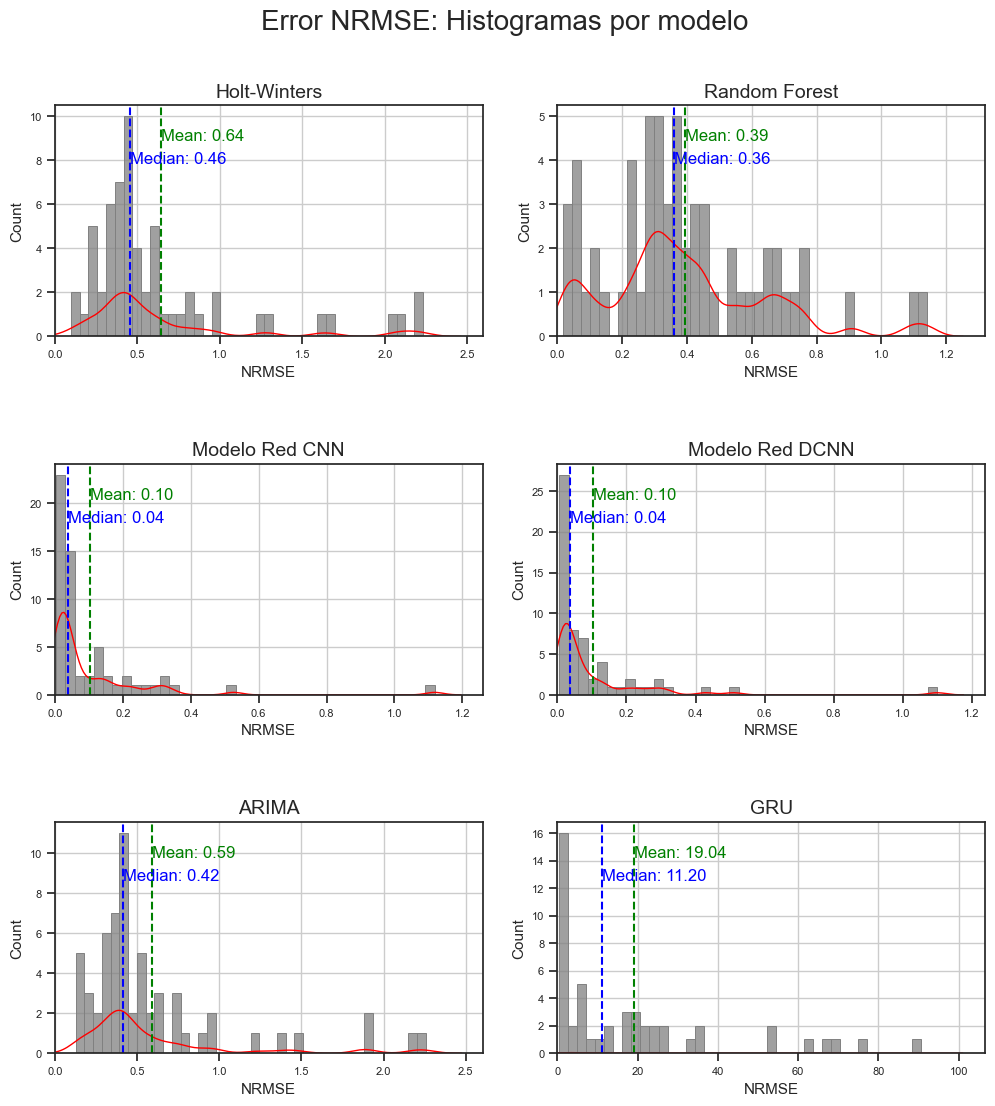

In [322]:
# Establecer el estilo de Seaborn
sns.set_style("ticks")

# Crear la figura y los subplots
fig, axs = plt.subplots(3, 2, figsize=(12, 12))

# Ajustar el espacio entre los subplots
plt.subplots_adjust(top=0.90, hspace=0.55, wspace=0.175)

# Parámetros de las fuentes
font_size_title = 14
font_size_labels = 11
font_size_ticks = 8

# Ajustar los parámetros de las fuentes
plt.rcParams.update({
    'axes.titlesize': font_size_title,
    'axes.labelsize': font_size_labels,
    'xtick.labelsize': font_size_ticks,
    'ytick.labelsize': font_size_ticks
})

# Dibujar los histogramas
for ax, (name, data) in zip(axs.flat, histogram_data.items()):
    sns.histplot(data, bins=40, kde=False, ax=ax, stat='count', color='grey', edgecolor='grey') 
    sns.kdeplot(data, color='red', linewidth=1, ax=ax, bw_method=0.15) # Dibujar la línea KDE
    ax.set_title(name)
    ax.set_xlabel('NRMSE')
    ax.set_ylabel('Count')
    ax.set_xlim(left=0.0)
    ax.grid(True)

    # Agregar una línea vertical punteada en el valor medio
    mean_value = np.mean(data)
    ax.axvline(x=mean_value, color='green', linestyle='--')
    # Agregar una línea vertical punteada en el valor de la moda
    median_value = median(data)
    ax.axvline(x=median_value, color='blue', linestyle='--')
    # Agregar etiqueta al lado de la línea vertical
    ax.text(mean_value, ax.get_ylim()[1]*0.9, f'Mean: {mean_value:.2f}', color='green', va='top')
    # Agregar etiqueta al lado de la línea vertical de la moda
    ax.text(median_value, ax.get_ylim()[1]*0.8, f'Median: {median_value:.2f}', color='blue', va='top')


# Agregar el título general
plt.suptitle('Error NRMSE: Histogramas por modelo', fontsize=20)

# Mostrar el gráfico
plt.show()


Comment: The convolutional neural network-based models offer the least error in the predictions made.

In third place would be the Random Forest model, although with a significantly higher NRMSE and a much more dispersed error histogram in comparison.

## 8.2. Conclusions <a id="82"></a>

The NRMSE error histograms from the previous section show that the proposed **Convolutional Neural Network (CNN)** and **Deep Convolutional Neural Network (DCNN)** models are superior to the other algorithms in the exercise in terms of predictive accuracy for the following reasons:

- They have the lowest average NRMSE error (10%) of all the models.
- Regarding consistency across all analyzed time series, the histogram shows that a large portion of the NRMSE observations cluster in areas of relatively low NRMSE: evidence of this is the median NRMSE value of 4%, indicating that 50% of predictions are below this error.

Despite both having similar precision (both are equally acceptable), when it comes to discriminating which one is better, the **DCNN** model has a slightly lower standard deviation (0.169847 vs 0.171815), making it a bit more consistent in results.

> Considering execution time vs. accuracy, the **CNN model** would be the winner as it requires less computation time (fewer parameters) than the DCNN.

[Back to the beginning of the document](#)
